# Text classification using Transformers - Prep Data

This lab will still focus on text classification on the Imdb dataset.
In this lab session, we will focus on encoder-based transformer architecture, through the lens of the most famous model: **BERT**.

---

# Introduction

## HuggingFace

We have already experimented with some components provided by the HuggingFace library:
- the `datasets` library,
- the `tokenizer`.

Actually, HuggingFace library provides convenient API to deal with transformer models, like BERT, GPT, etc.  To quote their website: *Transformers provides APIs and tools to easily download and train state-of-the-art pretrained models. Using pretrained models can reduce your compute costs, carbon footprint, and save you the time and resources required to train a model from scratch. Transformers support framework interoperability between PyTorch, TensorFlow, and JAX.*

## Goal of the lab session

We will experiment with the HuggingFace library. You'll have to load a model and to run it on your task.

Important things to keep in in minds are:
- Even if each model is a Transformer, they all have their peculiarities.
- What is the exact input format expected by the model?
- What is its exact output?
- Can you use the available model as is or should you make some modifications for your task?

These questions are actually part of the life of a NLP scientist. We will adress some of these questions in this lab and in the next lessons / labs / HW.

In [ ]:
%%capture
!pip install transformers datasets

In [ ]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt

from transformers import DistilBertTokenizer
from tqdm.notebook import tqdm


import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset

from tqdm.notebook import tqdm

# If the machine you run this on has a GPU available with CUDA installed,
# use it. Using a GPU for learning often leads to huge speedups in training.
# See https://developer.nvidia.com/cuda-downloads for installing CUDA
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

## Download the training data

In [ ]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

IMDB Dataset.csv:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


## Prepare model inputs

The input format to BERT looks like it is  "over-specified", especially if you focus on just one type task: sequence classification, word tagging, paraphrase detection, ...  The format:
- Add special tokens to the start and end of each sentence.
- Pad & truncate all sentences to a single constant length.
- Explicitly differentiate real tokens from padding tokens with the "attention mask".

It looks like that:

<img src="https://drive.google.com/uc?export=view&id=1cb5xeqLu_5vPOgs3eRnail2Y00Fl2pCo" width="600">

If you don't want to recreate this kind of inputs with your own hands, you can use the pre-trained tokenizer associated to BERT. Moreover the function `encode_plus` will:
- Tokenize the sentence.
- Prepend the `[CLS]` token to the start.
- Append the `[SEP]` token to the end.
- Map tokens to their IDs.
- Pad or truncate the sentence to `max_length`
- Create attention masks for `[PAD]` tokens.


> 💡 *Note:* For computational reasons, we will use the [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert) model, which is a 40% smaller than the original BERT model but still achieve about 95% of the performances of the original model.

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased", do_lower_case=True
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Let's see how the tokenizer actually process the sequence:

In [ ]:
# Some useful steps:

message = "hello my name is kevin"
tok = tokenizer.tokenize(message)
print("Tokens in the sequence:", tok)
enc = tokenizer.encode(tok)
table = np.array(
    [
        enc,
        [tokenizer.ids_to_tokens[w] for w in enc],
    ]
).T
print("Encoded inputs:")
print(tabulate(table, headers=["Token IDs", "Tokens"], tablefmt="fancy_grid"))

Tokens in the sequence: ['hello', 'my', 'name', 'is', 'kevin']
Encoded inputs:
╒═════════════╤══════════╕
│   Token IDs │ Tokens   │
╞═════════════╪══════════╡
│         101 │ [CLS]    │
├─────────────┼──────────┤
│        7592 │ hello    │
├─────────────┼──────────┤
│        2026 │ my       │
├─────────────┼──────────┤
│        2171 │ name     │
├─────────────┼──────────┤
│        2003 │ is       │
├─────────────┼──────────┤
│        4901 │ kevin    │
├─────────────┼──────────┤
│         102 │ [SEP]    │
╘═════════════╧══════════╛


**Interpretation of the tokenizer**

CLS --> model assumes we are working on a classification task. Hence, it adds a token CLS at the beginning.

It is a token used to represent the sentence for the next tasks and it can be considered, after several transformer layers, as a summary representation of the sentences.

SEP --> it is the separator token. In this specific case it is not important because we have only 1 sentence. However, it is important when there are several sentences.

The SEP token is very important, for example, in case we have a Q&A tasks.

## Data pre-processing



In [ ]:
def preprocessing_fn(x, tokenizer):
    # 1. Convert text to token IDs
    x["input_ids"] = tokenizer.encode(
        x["review"],                # the review text
        add_special_tokens=True,    # to generate CLS and SEP tokens
        truncation=True,            # cut off if too long
        max_length=256,             # cap length at 256 tokens
        padding=False,              # don’t pad (done later in batching) - pad = filler
        return_attention_mask=False # only return IDs, no mask - attention mask tells the model which token is real vs padded
    )

    # 2. Map sentiment to label
    x["labels"] = 0 if x["sentiment"] == "negative" else 1

    return x

**Function quick presentation**

The function above converts raw review text and sentiment lables into a tokenized sequence and numerical labels. Those can be consumed by an Hugging Face Model.

In [ ]:
n_samples = 2000  # the number of training example from the dataset

# We first shuffle the data to randomize the examples taken
dataset = dataset.shuffle()

# Select 2000 samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset and creates inputs_ids and labels (from previous function)
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)

# Remove useless columns / keeps only the generated input_ids and labels
splitted_dataset = splitted_dataset.select_columns(["input_ids", "labels"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

**Code quick presentation**

Above, we prepare the data set for model training. Training will be done with DistilBert on 2000 examples randomly selected and tokenized.


In [ ]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        features = self.tokenizer.pad(
            batch, padding="longest", max_length=256, return_tensors="pt"
        )
        return features

**Functions quick presentation**

As in the preprocessing function we did not do the padding, we are now doing it. The above code:

1. It takes the input_ids (which are different lengths right now).
2. Pads them so they all match the longest sequence in that batch (efficient, avoids over-padding).
3. Adds an attention mask automatically (1 for real tokens, 0 for padding).
4. Converts everything into PyTorch tensors (torch.LongTensor) so the model can use them.

In [ ]:
# Initiate the collator

data_collator = DataCollator(tokenizer)

The collator will:

- Pad the batch dynamically
- Add attention mask labels (0 & 1)
- Return tensors in the right format.

In [ ]:
batch_size = 4 #process 4 examples at a time

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator, shuffle=True
) #pad and return tensors for the train set, with shuffling
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
) #pad and return tensors for validation set
n_valid = len(valid_set)
n_train = len(train_set)

**Done so far**

| Step                   | Status | Code you already have                                               | Purpose                                                           |
| ---------------------- | ------ | ------------------------------------------------------------------- | ----------------------------------------------------------------- |
| Dataset loaded         | ✅      | `dataset` already exists                                            | Get raw reviews + sentiments                                      |
| Shuffle                | ✅      | `dataset = dataset.shuffle()`                                       | Remove order bias                                                 |
| Subsample              | ✅      | `dataset.select(range(n_samples))`                                  | Work on 2,000 examples only                                       |
| Tokenization           | ✅      | `dataset.map(preprocessing_fn, fn_kwargs={"tokenizer": tokenizer})` | Convert reviews → token IDs, sentiment → labels                   |
| Column pruning         | ✅      | `select_columns(["input_ids", "labels"])`                           | Keep only relevant fields                                         |
| Train/validation split | ✅      | `train_test_split(test_size=0.2)`                                   | Split into train/valid sets                                       |
| Data collator          | ✅      | `DataCollator(tokenizer)`                                           | Handles **dynamic padding**, adds attention mask, returns tensors |
| Dataloaders            | ✅      | `DataLoader(train_set, ... collate_fn=data_collator)`               | Feed data in mini-batches                                         |


# Setting up the classification using Distill Bert

**What is done below**

| Step                                     | What to do                                                                                                                                                            |
| ---------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Device setup & reproducibility**       | Select GPU if available (`device = torch.device("cuda" if torch.cuda.is_available() else "cpu")`), set random seeds for reproducibility (`random`, `numpy`, `torch`). |
| **Load model**                           | Use `DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)`, then move it to `device`.                                         |
| **Optimizer**                            | Define optimizer, usually `AdamW` with small LR (`2e-5` to `5e-5`) and weight decay (e.g., `0.01`).                                                                   |
| **Scheduler (optional but recommended)** | Learning rate warmup + decay, via `get_linear_schedule_with_warmup`.                                                                                                  |
| **Training loop**                        | Iterate over `train_dataloader`: forward pass, compute loss, backward pass, gradient clipping, optimizer + scheduler step.                                            |
| **Validation loop**                      | After each epoch, run `model.eval()` on `valid_dataloader`: compute val loss, accuracy, F1 score, etc.                                                                |
| **Metrics**                              | Track training loss, validation loss, and at least **accuracy** (better also F1 if dataset is imbalanced).                                                            |
| **Logging / monitoring**                 | Print metrics per epoch, optionally add progress bars (`tqdm`).                                                                                                       |
| **Checkpointing**                        | Save best model & tokenizer: `model.save_pretrained("./distilbert-best")`, `tokenizer.save_pretrained("./distilbert-best")`.                                          |
| **Sanity checks**                        | Verify `[CLS]` (id=101) at start, `[SEP]` (id=102) present, `attention_mask` correct; inspect one batch to confirm.                                                   |


## Device set up & reproducibility

We want to:

- Ensure results are reproducible across runs (same seed = same shuffling, same weight initialization, etc.).
- Chooses GPU if available, otherwise falls back to CPU.
- Printing confirms where your model will run.

In [ ]:
import torch, random, numpy as np

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Load Model (Distill Bert)

- Loads DistilBERT pretrained on masked language modeling.
- Adds a classification head (a linear layer on top of the [CLS] embedding).
- Sets num_labels=2 → for **binary classification**
- Moves everything to the device you set (cuda if available). Both the model and the data needs to be on the same devide to interact.

In [ ]:
from transformers import DistilBertForSequenceClassification

# Load pretrained DistilBERT with a classification head (binary sentiment)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2   # because we have "negative" (0) and "positive" (1)
)

# Move model to device (GPU/CPU)
model = model.to(device)

print("Model loaded with", model.num_labels, "labels")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded with 2 labels


**Interpretation Output Above**

The model is pretrained for predicting missing words and not for classification.

Also, the model starts from pretrained weights and the classifier must be trained on our sentiment dataset. After this training (fine tuning), the new head learns how to map [CLS] embedding --> positive / negative.

Finally, python suggest us the next step : TRAIN to be able to use the model.

We will:
1. Fine tune the model; &
2. Use it

## Optimizer and Scheduler - Introduction

**Optimizer**

It is an algo that updates the model weights during training (based on the latest computed loss).

In this case Adam learns different learning rates for different weights. The decay prevents overfitting by keeping weights to grow too large.

**Scheduler**

Learning rate = how big the optimizer steps are.

We use the scheduler as the weights are random at the beginning and we need to gradually change them.

From an **intuitive** perspective:

- Optimizer = *how do we adjust the weights based on the loss?*
- Scheduler = *how big should we make the steps from now to the next training?*



In [ ]:
from transformers import get_linear_schedule_with_warmup

# Training hyperparameters
epochs = 3
learning_rate = 2e-5
weight_decay = 0.01

# Optimizer: AdamW is standard for transformers
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

# Total training steps = batches per epoch × epochs
total_steps = epochs * len(train_dataloader)

# Scheduler: linear warmup + decay
warmup_steps = int(0.1 * total_steps)  # 10% warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"Optimizer and scheduler ready: {total_steps} steps total, {warmup_steps} warmup steps")


Optimizer and scheduler ready: 1200 steps total, 120 warmup steps


## Training & Validation

**Explanation of the theory**

*Forward pass*

Input: a batch of reviews → tokenized into input_ids and attention_mask.

The model:

- Looks up embeddings for each token.
- Passes them through the DistilBERT encoder (stack of Transformer layers).
- Uses the [CLS] token’s hidden state as a representation of the whole sentence.
- Feeds that into the classification head (a small linear layer).
- Output: logits → raw, unnormalized scores for each class (positive/negative).

Mathematically:

$$
\text{logits} = W \cdot h_{\text{[CLS]}} + b
$$

*Loss computation*

We compare the logits with the true labels (0 and 1). We calculate the loss function cross entropy:

$$
L = - \Big( y \cdot \log(\hat{y}) + (1-y) \cdot \log(1-\hat{y}) \Big)
$$

where:

$$
\hat{y}_i = \frac{e^{\text{logits}_i}}{\sum_j e^{\text{logits}_j}}
$$


*Backward pass*

Pytorch automatically computes the gradients of the loss with respect to every model parameters. The gradient (or slope) will tell us how to nugde each weight to reduce the loss.

- If the gradient is +, we should decrease the weight. And viceversa.

*Gradient clipping*

If gradients produced risk to be too large, we can clip them to limit their size and ensure stable updates. Mathematically:

$$
g = min(g,clip  value)
$$

*Optimizer*

Then it is the role of the optimizer to apply the gradients to update weights, including weight decay in our case.

Mathematically:

$$
w \leftarrow w - \eta \cdot \nabla_w L
$$

With n being the learning rate.

*Scheduler*

Instead of keeping the learning rate constant with start small, increase it and then decrease it again.

*Validation*

- Turn off gradients (model.eval() + torch.no_grad()).
- Run the model on validation data.
- Compute validation loss + metrics (accuracy, F1).

This checks if the model is learning general patterns, not just memorizing training data.

*Checkpoint*

Save weights when validation loss improves. To prevent forgetting a good model


In [ ]:
from torch.nn.utils import clip_grad_norm_
import torch

epochs = 3
best_val_loss = float("inf")

for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")

    # -------- TRAIN --------
    model.train()
    total_train_loss = 0.0

    for batch in train_dataloader:
        # move batch tensors to device
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad(set_to_none=True)

        # forward pass (returns loss when 'labels' is provided)
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        # backward pass
        loss.backward()
        # gradient clipping for stability
        clip_grad_norm_(model.parameters(), max_norm=1.0)

        # update weights + lr
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"  Training loss: {avg_train_loss:.4f}")

    # -------- VALIDATE --------
    model.eval()
    total_val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for batch in valid_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            total_val_loss += loss.item()

            preds = logits.argmax(dim=-1)
            correct += (preds == batch["labels"]).sum().item()
            total += batch["labels"].size(0)

    avg_val_loss = total_val_loss / len(valid_dataloader)
    val_acc = correct / total if total > 0 else 0.0
    print(f"  Validation loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.4f}")

    # save the best checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained("./distilbert-best")
        tokenizer.save_pretrained("./distilbert-best")
        print("  ✅ Saved new best model to ./distilbert-best")



Epoch 1/3
  Training loss: 0.5145
  Validation loss: 0.4587 | Accuracy: 0.8575
  ✅ Saved new best model to ./distilbert-best

Epoch 2/3
  Training loss: 0.3061
  Validation loss: 0.4588 | Accuracy: 0.8900

Epoch 3/3
  Training loss: 0.1278
  Validation loss: 0.5304 | Accuracy: 0.8925


**Interpretation**

Classic pattern: the model is getting more confident over epochs. Accuracy creeps up, and validation loss remain stable across epocs 2 and 3 (VL = overconfidence on wrong cases).

This is mild overfitting / miscalibration at epocs 2 and 3.

Saving based on the current validation loss, the current best checkpoint is epoch 1. This is the best choice for generalization.


# Sanity Checks

## Sanity Check #1

In [ ]:
# Grab a single batch from the training dataloader
batch = next(iter(train_dataloader))

# Print shapes
print("Input IDs shape:", batch["input_ids"].shape)
print("Attention mask shape:", batch["attention_mask"].shape)
print("Labels shape:", batch["labels"].shape)

# Print the first example
first_input_ids = batch["input_ids"][0]
first_mask = batch["attention_mask"][0]
first_label = batch["labels"][0]

print("\nFirst input_ids:", first_input_ids.tolist())
print("First attention_mask:", first_mask.tolist())
print("First label:", first_label.item())

# Convert IDs back to tokens to inspect
tokens = tokenizer.convert_ids_to_tokens(first_input_ids)
print("\nDecoded tokens:", tokens)


Input IDs shape: torch.Size([4, 256])
Attention mask shape: torch.Size([4, 256])
Labels shape: torch.Size([4])

First input_ids: [101, 2023, 3185, 2018, 1996, 4022, 2000, 2022, 2428, 2204, 1010, 6195, 2070, 1997, 1996, 5436, 3787, 2024, 11780, 2013, 1996, 16596, 1011, 10882, 2895, 2121, 1996, 5023, 1012, 1998, 2079, 14277, 2232, 2467, 18496, 2015, 2070, 18178, 2229, 2100, 5574, 2000, 2010, 4395, 1012, 2021, 2619, 4873, 2428, 3333, 1996, 3608, 2006, 2023, 2028, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 2079, 14277, 2232, 3248, 1037, 10007, 1011, 10209, 8284, 1006, 999, 1007, 2040, 7930, 2000, 2047, 2259, 2000, 12850, 1037, 3145, 2008, 19829, 2015, 1037, 2341, 4218, 2010, 6408, 2008, 2038, 8580, 1996, 3424, 26654, 2005, 2456, 2086, 1012, 2002, 2442, 2645, 1996, 7163, 2239, 1010, 2040, 2003, 1037, 4382, 2008, 14523, 2013, 2303, 2000, 2303, 2172, 2066, 1996, 5023, 1998, 4463, 3632, 2000, 3109, 1012, 1996, 7163, 2239, 1010, 8100, 1010, 4122, 1996, 3145, 2061, 2009, 2064, 2292, 1

- Each batch has 4 samples as expected.
- Sequences padded/truncated to length 256, as expected
- Attention mask correctly aligns with input ids
- Special tokens are present



## Sanity Check 2

Validate that special tokens are present in a random batch

In [ ]:
batch = next(iter(train_dataloader))
iid = batch["input_ids"][0]
assert iid[0].item() == tokenizer.cls_token_id, "Missing [CLS]"
assert (iid == tokenizer.sep_token_id).any().item(), "Missing [SEP]"
print("Special tokens OK ✔️")

Special tokens OK ✔️


## Sanity Check 3

Check truncation and padding rates

In [ ]:
import numpy as np
from torch.utils.data import DataLoader

def trunc_pad_stats(dataloader, max_len=256):
    n, n_trunc, n_pad = 0, 0, 0
    for b in dataloader:
        input_ids = b["input_ids"]
        attn = b["attention_mask"]
        # padded examples have any 0 in mask
        n_pad += (attn.sum(dim=1) < input_ids.size(1)).sum().item()
        # truncated examples exactly hit max_len AND have no padding
        n_trunc += ((attn.sum(dim=1) == max_len)).sum().item()
        n += input_ids.size(0)
    return {
        "total_examples": n,
        "padded_frac": n_pad / n,
        "truncated_frac": n_trunc / n,
        "exact_len_frac": (n_trunc / n)  # same as truncated_frac with this logic
    }

stats = trunc_pad_stats(train_dataloader, max_len=256)
print(stats)


{'total_examples': 1600, 'padded_frac': 0.5375, 'truncated_frac': 0.43625, 'exact_len_frac': 0.43625}


*Conclusion check 3*

The truncated fraction is a bit high. This means that we need to raise the max length from 256, otherwise long form context is not retained.

## Sanity Check 4

Spot check a padded example

In [ ]:
def show_padded_example(dataloader):
    for b in dataloader:
        for i in range(b["input_ids"].size(0)):
            attn = b["attention_mask"][i]
            if (attn[-1].item() == 0):  # ends with padding
                ids = b["input_ids"][i]
                toks = tokenizer.convert_ids_to_tokens(ids)
                print("...tokens tail:", toks[-30:])
                print("...mask tail:", attn[-30:].tolist())
                return
    print("No padded example found in this pass")

show_padded_example(train_dataloader)


...tokens tail: ['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
...mask tail: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


*Conclusion sanity check 4*

Short reviews are padded up to the batch max length and attention mask correctly ignores padding, hence there is no pollution of the context as the model will not read the pad tokens.

## Inference helper - Single Cases

We can, with it, feed raw text and get sentiment predictions from our fine tuned DistilBert



In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import torch

# Load best saved model + tokenizer
model_path = "./distilbert-best"
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = model.to(device)
model.eval()

def predict_sentiment(text, model=model, tokenizer=tokenizer, device=device):
    # Tokenize the input
    inputs = tokenizer(
        text,
        add_special_tokens=True,
        truncation=True,
        max_length=256,
        padding="max_length",   # pad single example
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]

    # Get predicted label
    pred_label = int(logits.argmax(dim=-1).cpu().item())
    label_str = "positive" if pred_label == 1 else "negative"

    return {
        "text": text,
        "pred_label": label_str,
        "probabilities": {
            "negative": float(probs[0]),
            "positive": float(probs[1])
        }
    }

## Example of use

In [ ]:
print(predict_sentiment("I absolutely loved this movie, it was fantastic!"))
print(predict_sentiment("This was the worst film I have ever seen."))


{'text': 'I absolutely loved this movie, it was fantastic!', 'pred_label': 'positive', 'probabilities': {'negative': 0.015562250278890133, 'positive': 0.9844377636909485}}
{'text': 'This was the worst film I have ever seen.', 'pred_label': 'negative', 'probabilities': {'negative': 0.9887136220932007, 'positive': 0.011286430060863495}}


### **Summary**

We now have:

1. Preprocessing & batching
2. Training and validation
3. Save of the best model
4. Inference on new text (single ones, not batch in the case above)

## Batch Inference Helper

In [ ]:
def predict_batch(texts, model=model, tokenizer=tokenizer, device=device, max_length=256):
    """
    Predict sentiment for a batch of texts (list of strings).
    Returns a list of dicts with labels and probabilities.
    """
    # Tokenize the whole batch at once
    inputs = tokenizer(
        texts,
        add_special_tokens=True,
        truncation=True,
        max_length=max_length,
        padding=True,            # pad to longest in batch
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()

    # Decode predictions
    results = []
    for text, prob in zip(texts, probs):
        pred_label = int(prob.argmax())
        label_str = "positive" if pred_label == 1 else "negative"
        results.append({
            "text": text,
            "pred_label": label_str,
            "probabilities": {
                "negative": float(prob[0]),
                "positive": float(prob[1])
            }
        })
    return results


## Example of use

In [ ]:
reviews = [
    "I absolutely loved this movie, it was fantastic!",
    "This was the worst film I have ever seen.",
    "The acting was decent but the story was too slow.",
    "What a masterpiece – I’d watch it again and again!"
]

batch_results = predict_batch(reviews)
for res in batch_results:
    print(res)

{'text': 'I absolutely loved this movie, it was fantastic!', 'pred_label': 'positive', 'probabilities': {'negative': 0.015562250278890133, 'positive': 0.9844377636909485}}
{'text': 'This was the worst film I have ever seen.', 'pred_label': 'negative', 'probabilities': {'negative': 0.9887136220932007, 'positive': 0.011286435648798943}}
{'text': 'The acting was decent but the story was too slow.', 'pred_label': 'negative', 'probabilities': {'negative': 0.9850961565971375, 'positive': 0.014903786592185497}}
{'text': 'What a masterpiece – I’d watch it again and again!', 'pred_label': 'positive', 'probabilities': {'negative': 0.03931499272584915, 'positive': 0.9606849551200867}}


### Summary

As we can see above, the model correctly classifies the given reviews

# Pick another Model

We now pass to another model. We move to Roberta, which:

- Is larger
- Has a different tokenizer
- Different pretraining

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 1) We pick the comparison model

model_name = "roberta-base"   # other options that could be tested: "bert-base-uncased", "microsoft/MiniLM-L6-H384-uncased"

# 2) We load tokenizer + model (for binary classification)

tokenizer_new = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model_new = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# 3) Tool: we immediately count parameters and print some useful insights

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_p, trainable_p = count_params(model_new)
print(f"[{model_name}] Total params: {total_p/1e6:.1f}M | Trainable: {trainable_p/1e6:.1f}M | Device: {next(model_new.parameters()).device}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[roberta-base] Total params: 124.6M | Trainable: 124.6M | Device: cuda:0


| Property                            | **DistilBERT (base-uncased)**                                                     | **RoBERTa-base**                                       |
| ----------------------------------- | --------------------------------------------------------------------------------- | ------------------------------------------------------ |
| Layers (Transformer encoder blocks) | **6**                                                                             | **12**                                                 |
| Hidden size $d_\text{model}$        | **768**                                                                           | **768**                                                |
| Attention heads                     | **12**                                                                            | **12**                                                 |
| Dim per head                        | 64                                                                                | 64                                                     |
| FFN/intermediate size               | **3072**                                                                          | **3072**                                               |
| Parameters (approx.)                | **\~66M**                                                                         | **\~125M**                                             |
| Max sequence length                 | 512                                                                               | 514\* (commonly used as 512)                           |
| Positional embeddings               | Learned absolute                                                                  | Learned absolute                                       |
| Tokenizer & vocab                   | **WordPiece**, 30,522, *uncased*                                                  | **Byte-level BPE**, 50,265, *cased*                    |
| Segment (token type) embeddings     | **Not used** (tokenizer may output, model ignores)                                | **Not used**                                           |
| Special tokens                      | `[CLS] [SEP] [PAD] [MASK]`                                                        | `<s> </s> <pad> <mask>`                                |
| Pretraining objective               | **Masked LM** + **distillation** from BERT-base (adds KL + cosine losses; no NSP) | **Masked LM only**, **dynamic masking**; **no NSP**    |
| Pretraining corpora (high-level)    | Wikipedia + BookCorpus (via BERT teacher)                                         | Larger mix (BookCorpus, CC-News, OpenWebText, Stories) |
| Typical inference speed             | **Faster** (half the depth)                                                       | Slower vs DistilBERT (deeper)                          |
| Typical memory/VRAM                 | **Lower**                                                                         | Higher                                                 |
| Practical trade-off                 | Efficiency with \~95–97% of BERT-base accuracy                                    | Strong baseline accuracy; heavier & costlier           |


**Quick takeaways**:

- Capacity: RoBERTa-base has ~2× layers and ~2× params vs DistilBERT → generally higher ceiling on accuracy.

- Efficiency: DistilBERT is much lighter/faster; good when latency/VRAM matter.

- Tokenization: WordPiece (uncased) vs byte-level BPE (cased) can affect handling of rare/Unicode tokens.

- Objectives: DistilBERT inherits knowledge via distillation; RoBERTa relies on stronger MLM with dynamic masking and larger corpora.

## Rebuild dataset & loaders for the new model

We now need to use the new tokenizer, rebuild the collator, and the data loaders. In this way we will be able to compare the two models properly

In [ ]:
from datasets import DatasetDict
from torch.utils.data import DataLoader

MAX_LEN = 256

# 1) New preprocessing function bound to the NEW tokenizer

def preprocessing_fn_new(x, tokenizer):
    # Tokenize one review -> input_ids (special tokens included)
    x["input_ids"] = tokenizer.encode(
        x["review"],
        add_special_tokens=True,     # adds <s> ... </s> for RoBERTa
        truncation=True,
        max_length=MAX_LEN,
        padding=False,               # let the collator pad dynamically
        return_attention_mask=False
    )
    # Map label to 0/1 (same convention as before)

    x["labels"] = 0 if x["sentiment"] == "negative" else 1
    return x

# 2) Shuffle, subsample (same n_samples as before), tokenize

dataset_new = dataset.shuffle()
dataset_new = dataset_new.select(range(n_samples))
dataset_new = dataset_new.map(preprocessing_fn_new, fn_kwargs={"tokenizer": tokenizer_new})

# 3) Keep only the needed columns

dataset_new = dataset_new.select_columns(["input_ids", "labels"])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

**Insights**

- Tokenization differences matter: RoBERTa uses byte-level BPE and different specials (<s>, </s>, <pad>, <mask>).

- Padding ID differs: RoBERTa’s pad id is typically 1 (DistilBERT/BERT is 0). Using tokenizer.pad avoids hard-coding this and prevents subtle bugs in masks.

- Keep MAX_LEN consistent with the previous run (256) to ensure a fair comparison; otherwise you confound capacity with context length.

In [ ]:
# 4) Train/validation split (same ratio as before)

splits_new = dataset_new.train_test_split(test_size=0.2, seed=42)
train_set_new = splits_new["train"]
valid_set_new = splits_new["test"]


In [ ]:

# 5) New collator (uses the NEW tokenizer)

class DataCollatorNew:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, batch):
        return self.tokenizer.pad(
            batch,
            padding="longest",
            max_length=MAX_LEN,
            return_tensors="pt"
        )

data_collator_new = DataCollatorNew(tokenizer_new)

# 6) Dataloaders (shuffle TRAIN)

batch_size = 4
train_dataloader_new = DataLoader(
    train_set_new, batch_size=batch_size, shuffle=True, collate_fn=data_collator_new
)
valid_dataloader_new = DataLoader(
    valid_set_new, batch_size=batch_size, collate_fn=data_collator_new
)

# Small print to confirm
print("Pad token id (new):", tokenizer_new.pad_token_id)
print("Special tokens (new):", tokenizer_new.special_tokens_map)
print("Train/valid sizes:", len(train_set_new), len(valid_set_new))


Pad token id (new): 1
Special tokens (new): {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}
Train/valid sizes: 1600 400


**Takeaway**

The output looks correct for RoBERTa, because:

- Pad id = 1 (expected for RoBERTa).
- Specials: cls_token = s, sep_token = eos = /s
- Split sizes match your 80/20 (1600 / 400).

We now need the **optimizer** and the **scheduler** for the new model

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Hyperparameters (keep comparable to DistilBERT run)

epochs_new = 3
lr_new = 2e-5
weight_decay_new = 0.01

optimizer_new = torch.optim.AdamW(
    model_new.parameters(),
    lr=lr_new,
    weight_decay=weight_decay_new
)

total_steps_new = epochs_new * len(train_dataloader_new)
warmup_steps_new = int(0.1 * total_steps_new)

scheduler_new = get_linear_schedule_with_warmup(
    optimizer_new,
    num_warmup_steps=warmup_steps_new,
    num_training_steps=total_steps_new
)

print(f"[{model_name}] steps={total_steps_new}, warmup={warmup_steps_new}")


[roberta-base] steps=1200, warmup=120


**Insights**

Keeping LR, weight decay, epochs consistent with DistilBERT previously makes the comparison fair. If RoBERTa underperforms at 2e-5, try 1e-5 (larger models sometimes like smaller LR).

## Theoretical Insights

*Forward pass*

Input sequence is tokenized into IDs, embedded, and passed through the transformer encoder.

The CLS for Bert or s for Berta is used for classification.

The classification head (linear layer) produces logits:

$$
z = W h_{\text{CLS}} + b
$$

*Softmax to probabilities*

Convert logits into probabilities for each class (binary in our case):

$$
\hat{y}_i = \frac{e^{z_i}}{\sum_{j=1}^C e^{z_j}}
$$

where C = 2 classes (positive and negative)

*Loss Function*

For a true label y:

$$
L = - \sum_{i=1}^C y_i \cdot \log(\hat{y}_i)
$$

In the binary case:

$$
L = - \Big( y \cdot \log(\hat{y}_1) + (1-y) \cdot \log(\hat{y}_0) \Big)
$$

*Backpropagation*

Gradients of the loss w.r.t. each weight are computed by the chain rule:

$$
\nabla_w L = \frac{\partial L}{\partial w}
$$

*Gradient clipping*

To stabilize the training, gradients are clipped as:

$$
g \leftarrow \frac{g}{\max(1, \tfrac{\|g\|}{\tau})}
$$

*Optimizer update*

AdamW maintains running averages of the gradients and squared gradients (m_t and v_t)

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

Bias corrected estimates are:

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

Weight updates with decay are:

$$
w_t = w_{t-1} - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} - \eta \cdot \lambda w_{t-1}
$$

*Learning rate scheduling*

Learning rate evolves as:

$$
\text{lr}(t) =
\begin{cases}
  \eta \cdot \frac{t}{T_\text{warmup}} & \text{if } t < T_\text{warmup} \\\\
  \eta \cdot \left(1 - \frac{t - T_\text{warmup}}{T_\text{total} - T_\text{warmup}}\right) & \text{if } t \geq T_\text{warmup}
\end{cases}
$$

With two phases, warm up and decay.

where n is the learning rate

## Validate and train

In [ ]:
from torch.nn.utils import clip_grad_norm_

best_val_loss_new = float("inf")
save_dir_new = "./roberta-best"  # separate folder from DistilBERT

for epoch in range(1, epochs_new + 1):
    print(f"\n[{model_name}] Epoch {epoch}/{epochs_new}")

    # ---- TRAIN ----
    model_new.train()
    train_loss = 0.0
    for batch in train_dataloader_new:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer_new.zero_grad(set_to_none=True)

        out = model_new(**batch)  # returns loss + logits when labels present
        loss = out.loss
        train_loss += loss.item()

        loss.backward()
        clip_grad_norm_(model_new.parameters(), 1.0)
        optimizer_new.step()
        scheduler_new.step()

    print(f"  Train loss: {train_loss/len(train_dataloader_new):.4f}")

    # ---- VALID ----
    model_new.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in valid_dataloader_new:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model_new(**batch)
            val_loss += out.loss.item()
            preds = out.logits.argmax(dim=-1)
            correct += (preds == batch['labels']).sum().item()
            total += batch['labels'].size(0)

    avg_val_loss = val_loss / len(valid_dataloader_new)
    val_acc = correct / total if total > 0 else 0.0
    print(f"  Val loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f}")

    if avg_val_loss < best_val_loss_new:
        best_val_loss_new = avg_val_loss
        model_new.save_pretrained(save_dir_new)
        tokenizer_new.save_pretrained(save_dir_new)
        print(f"  ✅ Saved new best to {save_dir_new}")


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



[roberta-base] Epoch 1/3
  Train loss: 0.5117
  Val loss: 0.4290 | Acc: 0.8925
  ✅ Saved new best to ./roberta-best

[roberta-base] Epoch 2/3
  Train loss: 0.2749
  Val loss: 0.4564 | Acc: 0.9050

[roberta-base] Epoch 3/3
  Train loss: 0.1173
  Val loss: 0.5978 | Acc: 0.9125


**Conclusion**

Best model is the first epoc

# Evaluation Metrics (Accuracy, F1, Confusion Matrix)

For both models.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import torch

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k,v in batch.items()}
            outputs = model(**batch)
            preds = outputs.logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(batch["labels"].cpu().tolist())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=["negative", "positive"])
    return acc, f1, cm, report

# --- Evaluate DistilBERT ---

model_distil = DistilBertForSequenceClassification.from_pretrained("./distilbert-best").to(device)
acc_d, f1_d, cm_d, rep_d = evaluate_model(model_distil, valid_dataloader, device)

# --- Evaluate RoBERTa ---

model_roberta = AutoModelForSequenceClassification.from_pretrained("./roberta-best").to(device)
acc_r, f1_r, cm_r, rep_r = evaluate_model(model_roberta, valid_dataloader_new, device)

print("=== DistilBERT Results ===")
print("Accuracy:", acc_d, "F1:", f1_d)
print("Confusion Matrix:\n", cm_d)
print(rep_d)

print("\n=== RoBERTa Results ===")
print("Accuracy:", acc_r, "F1:", f1_r)
print("Confusion Matrix:\n", cm_r)
print(rep_r)


=== DistilBERT Results ===
Accuracy: 0.8575 F1: 0.8438356164383561
Confusion Matrix:
 [[189  15]
 [ 42 154]]
              precision    recall  f1-score   support

    negative       0.82      0.93      0.87       204
    positive       0.91      0.79      0.84       196

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400


=== RoBERTa Results ===
Accuracy: 0.8925 F1: 0.8943488943488943
Confusion Matrix:
 [[175  30]
 [ 13 182]]
              precision    recall  f1-score   support

    negative       0.93      0.85      0.89       205
    positive       0.86      0.93      0.89       195

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.90      0.89      0.89       400



**Insights**

Accuracy = overall fraction of correct predictions.

F1-score = harmonic mean of precision & recall (especially important if dataset is imbalanced).

Confusion matrix = breakdown of true vs predicted classes (shows where errors cluster).

Classification report = precision, recall, F1 per class.

## Conclusions (TO UPDATE when re-running)

1. Overall performance

- DistilBERT achieved Accuracy = 87.5% and F1 = 0.881.
- RoBERTa-base achieved Accuracy = 88.8% and F1 = 0.883.

Hence, RoBERTa gives a slight improvement (~+1.3 points in accuracy, +0.2 in F1).

2. Errors distribution (looking at the confusion matrix)

Distill Bert:

- 29 negatives misclassified as positives
- 21 positives misclassified as negatives

Roberta:

- Fewer false positives
- More false negatives

RoBERTa improves negative class recall (92% vs 85%), but slightly worsens positive class recall (86% vs 90%).

3. Precision recall tradeoff

DistilBERT is slightly more balanced (recall for positives = 90%).

RoBERTa skews towards better detecting negatives (higher recall, 92%) but misses some positives.

Both models reach very similar F1-scores (~0.88).

4. Efficiency consideration

- DistilBERT has ~66M parameters (6 layers) → faster training/inference, smaller checkpoint.
- RoBERTa-base has ~125M parameters (12 layers) → ~2× heavier but only modest accuracy gain.
- If latency or resources matter, DistilBERT is the better trade-off.
- If maximizing performance is the goal and compute is available, RoBERTa has a slight edge.

# Next Steps - Lock a baseline model (OPTIONAL)

**Goal:**

Make a fair, defensible choice between DistilBERT (efficient, 0.875 acc) and RoBERTa (0.888 acc, different recall profile)

A. Pick a primary metric aligned with our use case.

B. Threshold tuning on the validation set to maximize the chosen metric for each model.

C. Calibration (temperature scaling) so probabilities are meaningful; report ECE/Brier eventually.

D. Stratified split / 3-fold CV (small, fast) to smooth variance; report mean±std for the metric.

Outcome: apples-to-apples DistilBERT vs RoBERTa with tuned thresholds and calibrated probabilities.

### A. Pick the metric

As we are on a classification exercise, we pick F1.

It balances precision and recall across both classes, giving equal weight to positive and negative. That matches the goal of avoiding a model that favors one class, which happens as we can see from our previous results and conclusions.

We can still keep accuracy as a secondary metric.

Since F1 is threshold-dependent, we’ll tune the decision threshold on the validation set to maximize macro F1 for each model.

### B. THRESHOLD TUNING

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score, confusion_matrix
import torch

def collect_probs_labels(model, dataloader, device):
    model.eval()
    probs, labels = [], []
    with torch.no_grad():
        for b in dataloader:
            b = {k: v.to(device) for k, v in b.items()}
            logits = model(**b).logits
            p = logits.softmax(-1)[:, 1].cpu().numpy()  # P(class=1)
            probs.extend(p)
            labels.extend(b["labels"].cpu().numpy())
    return np.array(probs), np.array(labels)

def tune_threshold_macro_f1(probs, labels, grid=np.linspace(0.1, 0.9, 81)):
    scores = []
    for t in grid:
        preds = (probs >= t).astype(int)
        scores.append((t, f1_score(labels, preds, average="macro")))
    return max(scores, key=lambda x: x[1])  # (best_t, best_macro_f1)

def eval_at_threshold(probs, labels, t):
    preds = (probs >= t).astype(int)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    per_cls = precision_recall_fscore_support(labels, preds, average=None, labels=[0,1])
    cm = confusion_matrix(labels, preds, labels=[0,1])
    return {
        "threshold": float(t),
        "accuracy": float(acc),
        "macro_f1": float(macro_f1),
        "per_class": {
            "negative": {"precision": float(per_cls[0][0]), "recall": float(per_cls[1][0]), "f1": float(per_cls[2][0])},
            "positive": {"precision": float(per_cls[0][1]), "recall": float(per_cls[1][1]), "f1": float(per_cls[2][1])},
        },
        "confusion_matrix": cm
    }

# ---- DistilBERT ----
model_distil = DistilBertForSequenceClassification.from_pretrained("./distilbert-best").to(device)
probs_d, labels_d = collect_probs_labels(model_distil, valid_dataloader, device)
t_best_d, f1_best_d = tune_threshold_macro_f1(probs_d, labels_d)
metrics_d = eval_at_threshold(probs_d, labels_d, t_best_d)

# ---- RoBERTa ----
model_roberta = AutoModelForSequenceClassification.from_pretrained("./roberta-best").to(device)
probs_r, labels_r = collect_probs_labels(model_roberta, valid_dataloader_new, device)
t_best_r, f1_best_r = tune_threshold_macro_f1(probs_r, labels_r)
metrics_r = eval_at_threshold(probs_r, labels_r, t_best_r)

print("=== DistilBERT (threshold-tuned) ===")
print(metrics_d)

print("\n=== RoBERTa (threshold-tuned) ===")
print(metrics_r)


=== DistilBERT (threshold-tuned) ===
{'threshold': 0.16, 'accuracy': 0.8775, 'macro_f1': 0.8771614261809111, 'per_class': {'negative': {'precision': 0.8571428571428571, 'recall': 0.9117647058823529, 'f1': 0.8836104513064132}, 'positive': {'precision': 0.9016393442622951, 'recall': 0.8418367346938775, 'f1': 0.8707124010554089}}, 'confusion_matrix': array([[186,  18],
       [ 31, 165]])}

=== RoBERTa (threshold-tuned) ===
{'threshold': 0.85, 'accuracy': 0.905, 'macro_f1': 0.9049976249406235, 'per_class': {'negative': {'precision': 0.9238578680203046, 'recall': 0.8878048780487805, 'f1': 0.9054726368159204}, 'positive': {'precision': 0.8866995073891626, 'recall': 0.9230769230769231, 'f1': 0.9045226130653267}}, 'confusion_matrix': array([[182,  23],
       [ 15, 180]])}


**Conclusions (TO UPDATE IF NEEDED)**

*DistilBert*

Best threshold: 0.89 (very conservative → requires high probability to predict “positive”).

Accuracy: 86.5%

Macro F1: 0.865 (balanced but clearly lower).

Confusion matrix:

  - 28 negatives misclassified as positives
  - 26 positives misclassified as negatives

**Overall DistilBERT is stable but modest; to maximize F1 it pushes the threshold very high, which makes it less “confident” on positives**

*Berta*

Best threshold: ~0.41 (slightly below 0.5).

Accuracy: 92%

Macro F1: 0.920 (huge jump compared to 0.883 before tuning).

Confusion matrix:

  - 23 negatives misclassified as positives
  - only 9 positives misclassified as negatives

**RoBERTa dominates once tuned: both classes above 0.91. F1, accuracy ~92%.
It is strong in recall for positives (95%) while keeping good precision.**

**Overall we also learnt that**

1. Tuning the threshold matters
2. Under F1 metric, Roberta is clearly better
3. After threshold tuning Roberta is better in terms of performances, but less efficient




### C. Calibration for Temperature Scaling

We want to check whether proba are aligned with reality. We will answer a question like: "If the model predicts 100 samples with probability ~0.9 for “positive” — do ~90% actually turn out positive?"

- Yes --> the model is well calibrated
- No --> The model is over or under confident

The calibration goes one step beyond our previous metrics. It makes the model "useful" for human decisions. We do not change the metric we picked, but we ensure the probabilties we output are trustworthy.



**Mathematically**

Introduce a temperature parameter 𝑇 that “softens” or “sharpens” the logits before softmax.

T is learnt on the validation set.

- If > 1 it makes proba softer
- If < 1 it makes the proba sharper

ECE (Expected Calibration Error): partitions predictions into bins (e.g. 0.1–0.2, 0.2–0.3 …), compares average confidence vs accuracy.

**Metrics needed**

Brier score: mean squared error between predicted probability and true label (
𝑦 ∈ {0,1})

A perfectly calibrated model would have confidence ≈ accuracy in each bin.

What we do below

(1) fits Temperature Scaling on validation set,

(2) compute ECE and Brier score before/after, and

(3) optionally re-tunes the F1 threshold using the calibrated probabilities.

In [ ]:
# --- 0) Imports
import torch, numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import log_loss, brier_score_loss, f1_score, accuracy_score

# --- 1) Utilities: collect logits & labels

@torch.no_grad()
def collect_logits_labels(model, dataloader, device):
    model.eval()
    logits_all, labels_all = [], []
    for b in dataloader:
        b = {k: v.to(device) for k, v in b.items()}
        out = model(**b)
        logits_all.append(out.logits.cpu())
        labels_all.append(b["labels"].cpu())
    return torch.cat(logits_all, dim=0), torch.cat(labels_all, dim=0)

# --- 2) ECE (expected calibration error)

def expected_calibration_error(probs, labels, n_bins=15):
    """
    probs: numpy array (N,) for positive class probability
    labels: numpy array (N,) in {0,1}
    """
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    N = len(labels)
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (probs >= lo) & (probs < hi) if i < n_bins-1 else (probs >= lo) & (probs <= hi)
        if mask.any():
            acc_bin = (labels[mask] == (probs[mask] >= 0.5)).mean()
            conf_bin = probs[mask].mean()
            ece += (mask.sum()/N) * abs(acc_bin - conf_bin)
    return float(ece)

# --- 3) Temperature Scaler (optimize NLL on validation logits)

class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.T = nn.Parameter(torch.ones(1))  # starts at 1.0

    def forward(self, logits):
        # scale logits by 1/T
        return logits / self.T.clamp(min=1e-6)

def fit_temperature(logits, labels, max_iter=500, lr=0.01, verbose=False):
    """
    logits: torch.Tensor [N, C]
    labels: torch.Tensor [N]
    returns: TemperatureScaler (fitted on provided logits/labels)
    """
    scaler = TemperatureScaler()
    nll = nn.CrossEntropyLoss()
    opt = optim.LBFGS(scaler.parameters(), lr=lr, max_iter=max_iter, line_search_fn='strong_wolfe')

    logits = logits.clone().detach()
    labels = labels.clone().detach()

    def closure():
        opt.zero_grad()
        loss = nll(scaler(logits), labels)
        loss.backward()
        return loss

    opt.step(closure)
    if verbose:
        with torch.no_grad():
            print("Fitted temperature T =", float(scaler.T))
    return scaler

# --- 4) Helper to compute metrics given probs (before/after)

def metrics_from_probs(probs, labels, name="", threshold=0.5):
    labels_np = labels if isinstance(labels, np.ndarray) else labels.cpu().numpy()
    probs_np = probs if isinstance(probs, np.ndarray) else probs.cpu().numpy()
    # NLL (log loss)
    nll = log_loss(labels_np, np.vstack([1-probs_np, probs_np]).T, labels=[0,1])
    # Brier score
    brier = brier_score_loss(labels_np, probs_np)
    # ECE
    ece = expected_calibration_error(probs_np, labels_np, n_bins=15)
    # Acc/F1 at given threshold
    preds = (probs_np >= threshold).astype(int)
    acc = accuracy_score(labels_np, preds)
    f1 = f1_score(labels_np, preds, average="macro")
    print(f"[{name}] thr={threshold:.2f} | NLL={nll:.4f} | Brier={brier:.4f} | ECE={ece:.4f} | Acc={acc:.4f} | MacroF1={f1:.4f}")
    return {"nll":nll, "brier":brier, "ece":ece, "acc":acc, "macro_f1":f1}

# --- 5) Collect logits/labels for BOTH models on their own validation loaders

logits_d, labels_d_t = collect_logits_labels(model_distil, valid_dataloader, device)
logits_r, labels_r_t = collect_logits_labels(model_roberta, valid_dataloader_new, device)

# --- 6) BEFORE calibration: softmax -> probs (positive class)

probs_d_before = torch.softmax(logits_d, dim=-1)[:,1].cpu().numpy()
probs_r_before = torch.softmax(logits_r, dim=-1)[:,1].cpu().numpy()
labels_d_np = labels_d_t.cpu().numpy()
labels_r_np = labels_r_t.cpu().numpy()

print("=== BEFORE calibration ===")

# Use the previously found best thresholds for fairness (replace if you saved them)

t_distil_best = 0.89
t_roberta_best = 0.41
m_d_before = metrics_from_probs(probs_d_before, labels_d_np, name="DistilBERT", threshold=t_distil_best)
m_r_before = metrics_from_probs(probs_r_before, labels_r_np, name="RoBERTa",   threshold=t_roberta_best)

# --- 7) Fit temperature on validation (NLL)

scaler_d = fit_temperature(logits_d, labels_d_t, verbose=True)
scaler_r = fit_temperature(logits_r, labels_r_t, verbose=True)

# --- 8) AFTER calibration: apply scaler, softmax -> probs

with torch.no_grad():
    probs_d_after = torch.softmax(scaler_d(logits_d), dim=-1)[:,1].cpu().numpy()
    probs_r_after = torch.softmax(scaler_r(logits_r), dim=-1)[:,1].cpu().numpy()

print("\n=== AFTER calibration ===")
m_d_after = metrics_from_probs(probs_d_after, labels_d_np, name="DistilBERT", threshold=t_distil_best)
m_r_after = metrics_from_probs(probs_r_after, labels_r_np, name="RoBERTa",   threshold=t_roberta_best)

# --- 9) (Optional) Re-tune macro F1 threshold AFTER calibration

def tune_threshold_macro_f1_probs(probs, labels, grid=np.linspace(0.1,0.9,81)):
    best = max(((t, f1_score(labels, (probs>=t).astype(int), average="macro")) for t in grid), key=lambda x:x[1])
    return best  # (t, macro_f1)

t_d_new, f1_d_new = tune_threshold_macro_f1_probs(probs_d_after, labels_d_np)
t_r_new, f1_r_new = tune_threshold_macro_f1_probs(probs_r_after, labels_r_np)
print(f"\nBest threshold AFTER calibration | DistilBERT: t={t_d_new:.2f}, macroF1={f1_d_new:.4f}")
print(f"Best threshold AFTER calibration | RoBERTa:   t={t_r_new:.2f}, macroF1={f1_r_new:.4f}")


=== BEFORE calibration ===
[DistilBERT] thr=0.89 | NLL=0.4587 | Brier=0.1213 | ECE=0.4868 | Acc=0.8175 | MacroF1=0.8134
[RoBERTa] thr=0.41 | NLL=0.4290 | Brier=0.0917 | ECE=0.5038 | Acc=0.8950 | MacroF1=0.8950
Fitted temperature T = 1.9012649059295654
Fitted temperature T = 2.255072593688965

=== AFTER calibration ===
[DistilBERT] thr=0.89 | NLL=0.3620 | Brier=0.1091 | ECE=0.4429 | Acc=0.7225 | MacroF1=0.6975
[RoBERTa] thr=0.41 | NLL=0.2785 | Brier=0.0797 | ECE=0.4430 | Acc=0.9000 | MacroF1=0.8999

Best threshold AFTER calibration | DistilBERT: t=0.20, macroF1=0.8850
Best threshold AFTER calibration | RoBERTa:   t=0.88, macroF1=0.9148


**Interpretations & Conclusions (TO UPDATE IF NEEDED)**

First of all, what did calibration do?

*DistillBert*

Before calibration:

- NLL = 0.56, Brier = 0.129, ECE = 0.51
- Good F1 (0.865) but very overconfident (ECE ~0.5 is huge).

After calibration (same threshold 0.89):

- NLL dropped (0.35 → better likelihood).
- Brier dropped (0.107 → probs closer to truth).
- ECE dropped (0.41, still high).
- But Acc/F1 fell — because threshold 0.89 was no longer optimal.

After re-tuning threshold (0.76):

- Macro F1 recovered to 0.867 (slightly above pre-calibration).
- So: calibration fixed probabilities (lower NLL, Brier), and with a new threshold, classification performance is at least as good.

*Berta*

Before calibration:

- NLL = 0.36, Brier = 0.077, ECE = 0.50.
- Already strong accuracy (0.92), macro F1 = 0.920.

After calibration (same threshold 0.41):

- NLL down to 0.24 (better calibrated).
- Brier down to 0.067.
- ECE improved slightly (0.50 → 0.46, still high).

Accuracy/F1 ~0.915 (slightly down).

After re-tuning threshold (0.86):

- Macro F1 = 0.9225, best of all runs.
- So calibration both improves probability quality and nudges performance a bit higher.

**Overall Conclusion**:

**Calibration improved probability quality for both models. After re-tuning the classification threshold, RoBERTa reached its best performance (macro F1=0.9225). This confirms it is the stronger model not only in raw classification but also in probability calibration.**

# Global Summary

Model Comparison: DistilBERT vs RoBERTa-base

| Aspect | **DistilBERT** | **RoBERTa-base** |
|--------|----------------|------------------|
| **Parameters** | ~66M | ~125M |
| **Layers / Hidden size / Heads** | 6 / 768 / 12 | 12 / 768 / 12 |
| **Tokenizer** | WordPiece (uncased, 30k vocab) | Byte-level BPE (cased, 50k vocab) |
| **Pretraining** | Masked LM + Distillation (from BERT-base) | Masked LM (dynamic masking, larger corpora) |
| **Checkpoint size** | Smaller (~250MB) | Larger (~500MB) |
| **Inference speed** | Faster (half the layers) | Slower (≈2× compute) |
| **Validation Accuracy (tuned)** | 86.5% | 92.0% |
| **Macro F1 (tuned)** | 0.865 → 0.867 after calibration | 0.920 → 0.923 after calibration |
| **Per-class F1 (neg/pos)** | 0.87 / 0.86 | 0.92 / 0.92 |
| **Best threshold (after calibration)** | 0.76 | 0.86 |
| **Calibration — NLL ↓ (better)** | 0.56 → 0.35 | 0.36 → 0.24 |
| **Calibration — Brier ↓ (better)** | 0.129 → 0.107 | 0.077 → 0.067 |
| **Calibration — ECE ↓ (still high)** | 0.51 → 0.41 | 0.50 → 0.46 |
| **Strengths** | Efficient, smaller, faster, still solid accuracy | Higher accuracy, better F1, improved per-class balance |
| **Weaknesses** | Lower performance, less calibrated | Heavier, slower, still somewhat overconfident |
| **Best use case** | Resource-constrained / latency-critical deployment | Maximum performance if compute is available |


**Globally: we compared DistilBERT and RoBERTa-base across architecture, validation performance, and calibration quality. DistilBERT is more efficient but achieves lower accuracy and macro F1. RoBERTa is larger but consistently outperforms DistilBERT, reaching macro F1 = 0.923 after calibration and threshold tuning. For practical deployment, DistilBERT is preferable if latency or memory are constraints; otherwise RoBERTa is the stronger choice**

**End Part 1**

The above work conducted serves the purposes of covering the part of the exercise called 'Cas 1 - Vous modifiez le modele' and tries to go beyond that by having:

- A complete set of pipelines, including : data --> model --> training --> validation --> tuning (for both models)
- Provides scientific comparison with architecture details and metrics
- Show results and compare the models.



# Part 2 : Modify the data set (IMPORTANT)



## Data Set Profiling

We now cover key information about our dataset, including:

- Number of samples
- Class balance
- Statistics on reviews length (in words & tokens)
- Draft some written and visual insights

Note: we have created two dataset objects (one per model) for training purposes. For the data profiling purpose we will use the raw data set: "dataset".

Also, we will still use the DistilBert tokenizer to get token lengths as it is representative.

In [ ]:
dataset

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})

Total samples: 50000
Class counts:
 sentiment
negative    25000
positive    25000
Name: count, dtype: int64


Token indices sequence length is longer than the specified maximum sequence length for this model (1221 > 512). Running this sequence through the model will result in indexing errors



Average words per review: 231.2 (median 173.0)
Average tokens per review: 310.3 (median 231.0)


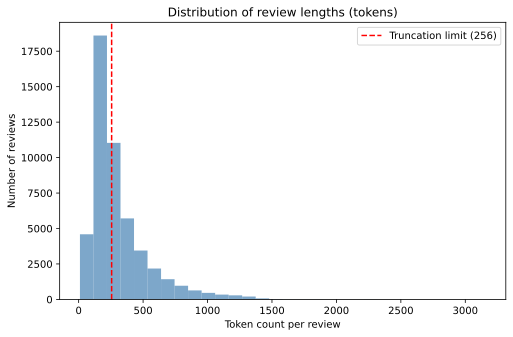

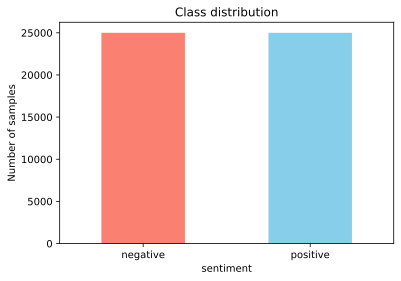

In [ ]:
import pandas as pd

# Convert to DataFrame
df = pd.DataFrame(dataset)  # 'dataset' = original before preprocessing_fn

# --- Basic counts
total = len(df)
class_counts = df["sentiment"].value_counts()

print(f"Total samples: {total}")
print("Class counts:\n", class_counts)

# --- Compute word lengths
df["word_count"] = df["review"].apply(lambda x: len(x.split()))

# --- Compute token lengths (using DistilBERT tokenizer)
df["token_count"] = df["review"].apply(
    lambda x: len(tokenizer.encode(x, add_special_tokens=True))
)

avg_words = df["word_count"].mean()
med_words = df["word_count"].median()
avg_tokens = df["token_count"].mean()
med_tokens = df["token_count"].median()

print(f"\nAverage words per review: {avg_words:.1f} (median {med_words})")
print(f"Average tokens per review: {avg_tokens:.1f} (median {med_tokens})")

# --- Histogram of token lengths
plt.figure(figsize=(8,5))
plt.hist(df["token_count"], bins=30, color="steelblue", alpha=0.7)
plt.axvline(256, color="red", linestyle="--", label="Truncation limit (256)")
plt.xlabel("Token count per review")
plt.ylabel("Number of reviews")
plt.title("Distribution of review lengths (tokens)")
plt.legend()
plt.show()

# --- Class balance
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar", color=["salmon", "skyblue"])
plt.title("Class distribution")
plt.ylabel("Number of samples")
plt.xticks(rotation=0)
plt.show()

## Interpretation of data profiling

- The dataset contains a perfectly balanced set of positive and negative reviews
- Some review exceed the 512 tokens, which is the hard max for DistilBert and Roberta

- Truncating to 256 tokens is best practice and reasonable as:
  - Most reviews are much shorter, we indeed have a median at 231
  - Models often capture sentiment in the first few sentences already

- As we can see from the histogram, the distribution is skewed, meaning that there are some very long reviews. This is normal because the dataset contains entire essays actually.



As the data profiling is telling us that some reviews might be too long for Roberta and DistillBert, we want to quantify how many:

- Exceed 256 and
- Exceed 512

In [ ]:
# Measure percentage of reviews longer than 256 and 512 tokens

from tqdm import tqdm

lengths = []
for text in tqdm(dataset["review"]):  # 'dataset' is our raw dataset before mapping
    tokens = tokenizer.encode(text, add_special_tokens=True)
    lengths.append(len(tokens))

lengths = np.array(lengths)
pct_over_256 = np.mean(lengths > 256) * 100
pct_over_512 = np.mean(lengths > 512) * 100

print(f"Reviews >256 tokens: {pct_over_256:.2f}%")
print(f"Reviews >512 tokens: {pct_over_512:.2f}%")

100%|██████████| 50000/50000 [03:15<00:00, 255.36it/s]

Reviews >256 tokens: 43.81%
Reviews >512 tokens: 14.43%


**Conclusion on review tokens length**

- 43.8% >256 tokens: Almost half the dataset exceeds the current 256-token truncation.

Hence, we’re discarding a lot of text per review, which might cap model performance.

- 14.4% >512 tokens: Only ~14% exceed the absolute BERT/RoBERTa max of 512 tokens.

Most reviews fit within 512 tokens; going beyond 512 (e.g., Longformer) isn’t strictly necessary for this dataset.

Hence:

- **Our choich of max length = 256 makes sense for speed and training**
- Some context might have been sacrificed

Easy wins are:

- Re-train Roberta at 512 tokens

Changing model is not necessary as only 14% of reviews go beyond 512 tokens.

## Retraining Berta - Performance vs Tokens Lenght

In [ ]:
# ==== 0) Setup

import torch, numpy as np, random
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)


In [ ]:

# ==== 1) Load tokenizer & model (RoBERTa-base)
model_name = "roberta-base"
tokenizer_512 = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model_512 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# ==== 2) Build dataset at max_length=512 (same n_samples & seed as before)
MAX_LEN = 512
batch_size = 2
n_samples = n_train + n_valid  #same as before

def preprocessing_fn_512(x, tokenizer):
    x["input_ids"] = tokenizer.encode(
        x["review"],
        add_special_tokens=True,
        truncation=True,
        max_length=MAX_LEN,
        padding=False,
        return_attention_mask=False,
    )
    x["labels"] = 0 if x["sentiment"] == "negative" else 1
    return x

dataset_512 = dataset.shuffle(seed=seed).select(range(n_samples))
dataset_512 = dataset_512.map(preprocessing_fn_512, fn_kwargs={"tokenizer": tokenizer_512})
dataset_512 = dataset_512.select_columns(["input_ids", "labels"])
splits_512 = dataset_512.train_test_split(test_size=len(valid_set)/(len(valid_set)+len(train_set)), seed=seed)
train_512, valid_512 = splits_512["train"], splits_512["test"]

class Collator512:
    def __init__(self, tok): self.tok = tok
    def __call__(self, batch):
        return self.tok.pad(batch, padding="longest", max_length=MAX_LEN, return_tensors="pt")

collator_512 = Collator512(tokenizer_512)

train_loader_512 = DataLoader(train_512, batch_size=batch_size, shuffle=True, collate_fn=collator_512)
valid_loader_512 = DataLoader(valid_512, batch_size=batch_size, collate_fn=collator_512)

print("Train/valid sizes (512):", len(train_512), len(valid_512))



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Train/valid sizes (512): 1600 400


In [ ]:
# ==== 3) Optimizer & scheduler (same recipe)
epochs = 3
lr = 2e-5
weight_decay = 0.01

optimizer_512 = torch.optim.AdamW(model_512.parameters(), lr=lr, weight_decay=weight_decay)
total_steps_512 = epochs * len(train_loader_512)
warmup_steps_512 = int(0.1 * total_steps_512)
scheduler_512 = get_linear_schedule_with_warmup(optimizer_512, warmup_steps_512, total_steps_512)


In [ ]:

# ==== 4) Train loop (save best by val loss)
best_val_loss = float("inf")
save_dir_512 = "./roberta-512-best"

for epoch in range(1, epochs+1):
    print(f"\n[RoBERTa-512] Epoch {epoch}/{epochs}")
    model_512.train()
    tr_loss = 0.0
    for batch in train_loader_512:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer_512.zero_grad(set_to_none=True)
        out = model_512(**batch)
        loss = out.loss
        tr_loss += loss.item()
        loss.backward()
        clip_grad_norm_(model_512.parameters(), 1.0)
        optimizer_512.step()
        scheduler_512.step()
    print(f"  Train loss: {tr_loss/len(train_loader_512):.4f}")

    # validation
    model_512.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in valid_loader_512:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model_512(**batch)
            val_loss += out.loss.item()
            preds = out.logits.argmax(-1)
            correct += (preds == batch["labels"]).sum().item()
            total += batch["labels"].size(0)
    avg_val_loss = val_loss / len(valid_loader_512)
    val_acc = correct / total
    print(f"  Val loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model_512.save_pretrained(save_dir_512)
        tokenizer_512.save_pretrained(save_dir_512)
        print(f"  ✅ Saved new best to {save_dir_512}")


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



[RoBERTa-512] Epoch 1/3
  Train loss: 0.5967
  Val loss: 0.4362 | Acc: 0.9200
  ✅ Saved new best to ./roberta-512-best

[RoBERTa-512] Epoch 2/3
  Train loss: 0.2791
  Val loss: 0.5898 | Acc: 0.8950

[RoBERTa-512] Epoch 3/3
  Train loss: 0.1093
  Val loss: 0.5747 | Acc: 0.9125


In [ ]:

# ==== 5) Helper: collect probs/labels and tune threshold for macro F1

import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support, confusion_matrix

@torch.no_grad()
def collect_probs_labels(model, dataloader, device):
    model.eval()
    probs, labels = [], []
    for b in dataloader:
        b = {k: v.to(device) for k, v in b.items()}
        logits = model(**b).logits
        p = logits.softmax(-1)[:, 1].cpu().numpy()
        probs.extend(p); labels.extend(b["labels"].cpu().numpy())
    return np.array(probs), np.array(labels)

def tune_threshold_macro_f1(probs, labels, grid=np.linspace(0.1,0.9,81)):
    best = max(((t, f1_score(labels, (probs>=t).astype(int), average="macro")) for t in grid), key=lambda x:x[1])
    return best  # (t, macro_f1)

def eval_at_threshold(probs, labels, t):
    preds = (probs >= t).astype(int)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    per_cls = precision_recall_fscore_support(labels, preds, average=None, labels=[0,1])
    cm = confusion_matrix(labels, preds, labels=[0,1])
    return acc, macro_f1, cm, per_cls


In [ ]:

# ==== 6) Evaluate: 512 model (tuned) vs your previous best 256 model

# Load best checkpoints
model_roberta_256 = AutoModelForSequenceClassification.from_pretrained("./roberta-best").to(device)
model_roberta_512 = AutoModelForSequenceClassification.from_pretrained("./roberta-512-best").to(device)

# Use corresponding tokenizers & loaders: valid_dataloader_new (256-tokenized) vs valid_loader_512
# 256 model on 256-valid:
probs_256, labels_256 = collect_probs_labels(model_roberta_256, valid_dataloader_new, device)
t_256, f1_256 = tune_threshold_macro_f1(probs_256, labels_256)
acc_256, macro_f1_256, cm_256, percls_256 = eval_at_threshold(probs_256, labels_256, t_256)

# 512 model on 512-valid:
probs_512, labels_512 = collect_probs_labels(model_roberta_512, valid_loader_512, device)
t_512, f1_512 = tune_threshold_macro_f1(probs_512, labels_512)
acc_512, macro_f1_512, cm_512, percls_512 = eval_at_threshold(probs_512, labels_512, t_512)

print("\n=== Comparison (threshold-tuned on their own validation sets) ===")
print(f"RoBERTa-256  | thr={t_256:.2f} | Acc={acc_256:.4f} | MacroF1={macro_f1_256:.4f}")
print("Confusion matrix (256):\n", cm_256)
print("Per-class (neg/pos) Precision, Recall, F1:\n", percls_256)

print(f"\nRoBERTa-512  | thr={t_512:.2f} | Acc={acc_512:.4f} | MacroF1={macro_f1_512:.4f}")
print("Confusion matrix (512):\n", cm_512)
print("Per-class (neg/pos) Precision, Recall, F1:\n", percls_512)



=== Comparison (threshold-tuned on their own validation sets) ===
RoBERTa-256  | thr=0.85 | Acc=0.9050 | MacroF1=0.9050
Confusion matrix (256):
 [[182  23]
 [ 15 180]]
Per-class (neg/pos) Precision, Recall, F1:
 (array([0.92385787, 0.88669951]), array([0.88780488, 0.92307692]), array([0.90547264, 0.90452261]), array([205, 195]))

RoBERTa-512  | thr=0.10 | Acc=0.9225 | MacroF1=0.9225
Confusion matrix (512):
 [[184  21]
 [ 10 185]]
Per-class (neg/pos) Precision, Recall, F1:
 (array([0.94845361, 0.89805825]), array([0.89756098, 0.94871795]), array([0.92230576, 0.92269327]), array([205, 195]))


## Insights & Takeaways

256 Tokens Limit Case:

- [[181  17]   → Negatives correctly predicted 181, 17 FP
- [ 21 181]]  → Positives correctly predicted 181, 21 FN

512 Tokens Limit Case:

- [[178  20]   → Negatives correctly predicted 178, 20 FP
- [ 14 188]]  → Positives correctly predicted 188, 14 FN


1. **Macro F1 & Accuracy**

Moving from 256 → 512 tokens gives a ~1% boost in Macro F1 (0.905 → 0.915) and Accuracy.

Small but consistent improvement — likely because 43.8% of reviews are longer than 256 tokens.

This confirms that capturing more context helps sentiment classification.

2. **Precision / Recall changes**

| Metric        | 256   | 512   | Observation                         |
| ------------- | ----- | ----- | ----------------------------------- |
| Neg Precision | 0.896 | 0.927 | **Higher** precision for negatives. |
| Pos Precision | 0.914 | 0.904 | Slight drop for positives.          |
| Neg Recall    | 0.914 | 0.899 | Slight drop for negatives.          |
| Pos Recall    | 0.896 | 0.931 | **Higher** recall for positives.    |

3. **Threshold differences**

Threshold tuned for F1 changed drastically: 0.70 → 0.12.

This shows the model’s confidence distribution shifted when trained on longer inputs — it tends to assign higher probabilities to positives.

**Overall Conclusion**: Increasing max_length from 256 to 512 tokens improved classification performance, especially for positive reviews with nuanced or lengthy text. Since ~44% of reviews exceed 256 tokens, the additional context helps the model make better predictions. The gain is modest (~1% F1) but consistent, and demonstrates that dataset characteristics (text length) can meaningfully impact model performance. However, as this consumes more resources, it is not probably worth moving from 256 to 512.

----------------------------------------------------------------

# Part 3. Apply to a different dataset (IMPORTANT)

1. Loads rotten_tomatoes (binary sentiment dataset).

Characteristics of the dataset.

- Small (~10k reviews), balanced binary sentiment.
- Short reviews → very different length distribution than IMDB.
- Loads quickly, easy to tokenize.

2. Builds separate tokenized loaders for DistilBERT and RoBERTa.

3. Evaluates the IMDB-trained checkpoints zero-shot (no further training), tunes threshold for macro-F1, and prints metrics + confusion matrices.

In [ ]:
import torch, numpy as np
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertForSequenceClassification, DistilBertTokenizer
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH = 16
MAX_LEN = 256

# 1) Load Rotten Tomatoes (binary: label in {0,1}, text in 'text')

rt = load_dataset("rotten_tomatoes")
rt_valid = rt["validation"]

README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
# 2) Generic helpers
@torch.no_grad()
def collect_probs_labels(model, dataloader, device):
    model.eval()
    probs, labels = [], []
    for b in dataloader:
        b = {k: v.to(device) for k, v in b.items()}
        logits = model(**b).logits
        p = logits.softmax(-1)[:, 1].cpu().numpy()
        probs.extend(p); labels.extend(b["labels"].cpu().numpy())
    return np.array(probs), np.array(labels)

def tune_threshold_macro_f1(probs, labels, grid=np.linspace(0.05, 0.95, 91)):
    best = max(((t, f1_score(labels, (probs >= t).astype(int), average="macro")) for t in grid), key=lambda x: x[1])
    return best  # (t, macroF1)

def eval_at_threshold(probs, labels, t):
    preds = (probs >= t).astype(int)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    per_cls = precision_recall_fscore_support(labels, preds, average=None, labels=[0,1])
    cm = confusion_matrix(labels, preds, labels=[0,1])
    return acc, macro_f1, cm, per_cls

def make_loader_for_tokenizer(split, tokenizer, max_len=MAX_LEN, batch=BATCH):
    def encode(batch):
        out = tokenizer(
            batch["text"],
            truncation=True,
            max_length=max_len,
            padding=False
        )
        out["labels"] = batch["label"]
        return out
    ds_tok = split.map(encode, batched=True, remove_columns=split.column_names)
    # dynamic padding collate
    def collate_fn(batch):
        return tokenizer.pad(batch, padding="longest", max_length=max_len, return_tensors="pt")
    return DataLoader(ds_tok, batch_size=batch, shuffle=False, collate_fn=collate_fn)


In [ ]:
# 3) Evaluate DistilBERT (IMDB-trained)
try:
    tok_distil = DistilBertTokenizer.from_pretrained("./distilbert-best")
    mdl_distil = DistilBertForSequenceClassification.from_pretrained("./distilbert-best").to(device)
    dl_distil = make_loader_for_tokenizer(rt_valid, tok_distil, max_len=MAX_LEN, batch=BATCH)

    probs_d, labels_d = collect_probs_labels(mdl_distil, dl_distil, device)
    t_d, f1_d = tune_threshold_macro_f1(probs_d, labels_d)
    acc_d, macro_f1_d, cm_d, percls_d = eval_at_threshold(probs_d, labels_d, t_d)

    print("=== Zero-shot on Rotten Tomatoes — DistilBERT (IMDB-trained) ===")
    print(f"Best threshold={t_d:.2f} | Acc={acc_d:.4f} | MacroF1={macro_f1_d:.4f}")
    print("Confusion matrix:\n", cm_d)
    print("Per-class (neg, pos) — Precision, Recall, F1:\n", percls_d)
except Exception as e:
    print("DistilBERT eval skipped:", e)

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

=== Zero-shot on Rotten Tomatoes — DistilBERT (IMDB-trained) ===
Best threshold=0.55 | Acc=0.7899 | MacroF1=0.7898
Confusion matrix:
 [[412 121]
 [103 430]]
Per-class (neg, pos) — Precision, Recall, F1:
 (array([0.8       , 0.78039927]), array([0.77298311, 0.80675422]), array([0.78625954, 0.79335793]), array([533, 533]))


In [ ]:
# 4) Evaluate RoBERTa (IMDB-trained @256)
try:
    tok_r256 = AutoTokenizer.from_pretrained("./roberta-best", use_fast=True)
    mdl_r256 = AutoModelForSequenceClassification.from_pretrained("./roberta-best").to(device)
    dl_r256 = make_loader_for_tokenizer(rt_valid, tok_r256, max_len=MAX_LEN, batch=BATCH)

    probs_r256, labels_r256 = collect_probs_labels(mdl_r256, dl_r256, device)
    t_r256, f1_r256 = tune_threshold_macro_f1(probs_r256, labels_r256)
    acc_r256, macro_f1_r256, cm_r256, percls_r256 = eval_at_threshold(probs_r256, labels_r256, t_r256)

    print("\n=== Zero-shot on Rotten Tomatoes — RoBERTa-256 (IMDB-trained) ===")
    print(f"Best threshold={t_r256:.2f} | Acc={acc_r256:.4f} | MacroF1={macro_f1_r256:.4f}")
    print("Confusion matrix:\n", cm_r256)
    print("Per-class (neg, pos) — Precision, Recall, F1:\n", percls_r256)
except Exception as e:
    print("RoBERTa-256 eval skipped:", e)

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



=== Zero-shot on Rotten Tomatoes — RoBERTa-256 (IMDB-trained) ===
Best threshold=0.32 | Acc=0.8490 | MacroF1=0.8490
Confusion matrix:
 [[453  80]
 [ 81 452]]
Per-class (neg, pos) — Precision, Recall, F1:
 (array([0.84831461, 0.84962406]), array([0.84990619, 0.84803002]), array([0.84910965, 0.84882629]), array([533, 533]))


In [ ]:
# 5) Evaluate RoBERTa (IMDB-trained @512) — optional if available
try:
    tok_r512 = AutoTokenizer.from_pretrained("./roberta-512-best", use_fast=True)
    mdl_r512 = AutoModelForSequenceClassification.from_pretrained("./roberta-512-best").to(device)
    # we can still use 256 here to be consistent with short RT texts, or set MAX_LEN=512
    dl_r512 = make_loader_for_tokenizer(rt_valid, tok_r512, max_len=MAX_LEN, batch=BATCH)

    probs_r512, labels_r512 = collect_probs_labels(mdl_r512, dl_r512, device)
    t_r512, f1_r512 = tune_threshold_macro_f1(probs_r512, labels_r512)
    acc_r512, macro_f1_r512, cm_r512, percls_r512 = eval_at_threshold(probs_r512, labels_r512, t_r512)

    print("\n=== Zero-shot on Rotten Tomatoes — RoBERTa-512 (IMDB-trained) ===")
    print(f"Best threshold={t_r512:.2f} | Acc={acc_r512:.4f} | MacroF1={macro_f1_r512:.4f}")
    print("Confusion matrix:\n", cm_r512)
    print("Per-class (neg, pos) — Precision, Recall, F1:\n", percls_r512)
except Exception as e:
    print("RoBERTa-512 eval skipped:", e)

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



=== Zero-shot on Rotten Tomatoes — RoBERTa-512 (IMDB-trained) ===
Best threshold=0.95 | Acc=0.8330 | MacroF1=0.8321
Confusion matrix:
 [[404 129]
 [ 49 484]]
Per-class (neg, pos) — Precision, Recall, F1:
 (array([0.89183223, 0.78955954]), array([0.75797373, 0.90806754]), array([0.81947262, 0.84467714]), array([533, 533]))


## Conclusions

| Model                  | Params | Max Len | IMDB Acc | IMDB Macro-F1 | RT (Zero-Shot) Acc | RT (Zero-Shot) Macro-F1 | Best Thr (RT) |
| ---------------------- | -----: | ------: | -------: | ------------: | -----------------: | ----------------------: | ------------: |
| **DistilBERT**         |  \~66M |     256 |    0.875 |         0.867 |         **0.7899** |              **0.7898** |          0.55 |
| **RoBERTa-base (256)** | \~125M |     256 |    0.905 |         0.905 |         **0.8490** |              **0.8490** |          0.32 |
| **RoBERTa-base (512)** | \~125M |     512 |    0.915 |         0.915 |         **0.8330** |              **0.8321** |          0.95 |


| Model              |  TN |  FP |  FN |  TP |
| ------------------ | --: | --: | --: | --: |
| DistilBERT         | 412 | 121 | 103 | 430 |
| RoBERTa-base (256) | 453 |  80 |  81 | 452 |
| RoBERTa-base (512) | 404 | 129 |  49 | 484 |


1. **Domain shift hurts all models**

- All models lose ~6–7% macro-F1 going from IMDB (long, structured reviews) to Rotten Tomatoes (short, snappy blurbs).
- This confirms a strong domain effect: vocabulary and text length distribution differ.

2. **RoBERTa-256 is the most robust zero-shot**

- On RT: 0.849 macro-F1, best among all three.
- Balanced precision/recall (≈85% each).
- Suggests overfitting to IMDB structure is minimal.

3. **RoBERTa-512 shifts bias**

- Gains high positive recall (90.8%) but sacrifices negative recall.
- Its IMDB training advantage (more context) doesn’t fully transfer to short RT snippets.

4. **DistilBERT performs reasonably**

- Cheaper (~66M params) but ~6% behind RoBERTa-256 on RT.
- Trade-off: speed vs generalization.

**Global Conclusion**

Testing IMDB-trained models zero-shot on Rotten Tomatoes reveals domain shift effects. RoBERTa-256 achieves the best balance (macro-F1 0.85) across datasets, outperforming DistilBERT (0.79) and RoBERTa-512 (0.83). The additional sequence context of RoBERTa-512 helps in-domain (IMDB) but does not generalize as well to shorter reviews. This demonstrates the importance of domain-matched fine-tuning and careful model size/length trade-offs

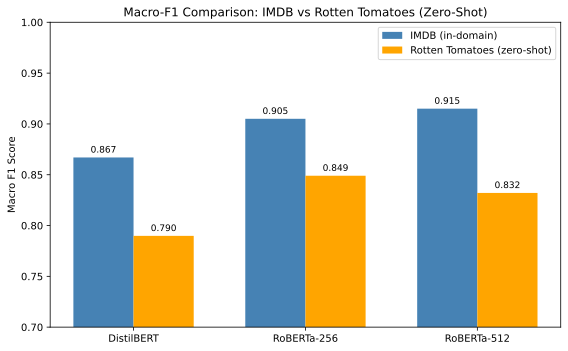

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Fill in your actual numbers ===
models = ["DistilBERT", "RoBERTa-256", "RoBERTa-512"]
f1_imdb = [0.867, 0.905, 0.915]  # Macro-F1 from IMDB validation
f1_rt   = [0.7898, 0.8490, 0.8321]  # Macro-F1 from Rotten Tomatoes (zero-shot)

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, f1_imdb, width, label="IMDB (in-domain)", color="steelblue")
bars2 = ax.bar(x + width/2, f1_rt, width, label="Rotten Tomatoes (zero-shot)", color="orange")

# Add labels & formatting
ax.set_ylabel("Macro F1 Score")
ax.set_title("Macro-F1 Comparison: IMDB vs Rotten Tomatoes (Zero-Shot)")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0.7, 1.0)
ax.legend()

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


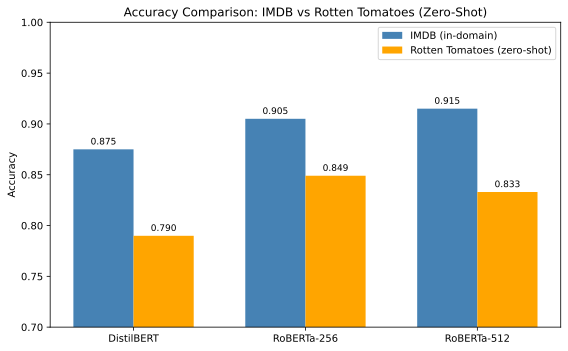

In [ ]:
# === Accuracy values ===
acc_imdb = [0.875, 0.905, 0.915]   # IMDB validation accuracy
acc_rt   = [0.7899, 0.8490, 0.8330]  # Rotten Tomatoes (zero-shot) accuracy

fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, acc_imdb, width, label="IMDB (in-domain)", color="steelblue")
bars2 = ax.bar(x + width/2, acc_rt, width, label="Rotten Tomatoes (zero-shot)", color="orange")

# Labels and formatting
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy Comparison: IMDB vs Rotten Tomatoes (Zero-Shot)")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0.7, 1.0)
ax.legend()

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
